# Accelerate SetFit Models with [`optimum-intel`](https://github.com/huggingface/optimum-intel)

In this notebook, we'll show how you can use the 🤗 `optimum-intel` package to speed up your SetFit models on **Intel CPUs**.\
In our experiments, we will be using a fine-tuned SetFit model based on `bge-small-en-v1.5` sentence transformer model and observe our performance increase.

### Prerequisites

* Linux OS
* Python 3.9+
* 3rd, 4th or 5th Generation Intel Xeon Processor (supports [bfloat16](https://www.intel.com/content/www/us/en/developer/articles/technical/pytorch-on-xeon-processors-with-bfloat16.html))

Since Google Colab doesn't meet the hardware requirement, it's incompatible with this notebook and will not see speedups from our optimizations.

Please run the following to ensure you meet the requirements.

In [1]:
import sys
import os
from time import sleep

os_info = !uname -o
os_type = os_info[0]
is_os_ok = "linux" in os_type.lower()
is_python_ver_ok = sys.version_info.major == 3 and sys.version_info.minor >=9
cpu_info = !lscpu
is_cpu_ok = "intel" in cpu_info.grep("vendor")[0].lower() and "bf16" in cpu_info.grep("flags")[0]
if not is_os_ok:
    print(f"This notebook requires a Linux type operating system, but you have {os_type}")
if not is_python_ver_ok:
    print(f"This notebook requires Python 3.9+ but your version is {sys.version.split()[0]}.")
if not is_cpu_ok:
    print(f"Your CPU does not support bfloat16.")
print(f"Notebook requirements {'' if is_os_ok and is_python_ver_ok and is_cpu_ok else 'not'} met.")

Requirements  met.


### Reproducibility Note
This notebook was tested on Ubuntu 22.04.3 LTS, Python 3.9.18 and a supported Intel Xeon processor.

To reproduce the maximum speeds reported in this notebook, please launch it locally, using `numactl`.\
`numactl` enables gaining better control on which resources you're running. It's best to run on a single socket (`-m 0`):\
`OMP_NUM_THREADS=<NUM_THREADS> numactl -C <CORES_RANGE> -m 0 jupyter notebook`

For example, if cores 0-59 are available, you can run with one thread per core like so:\
`OMP_NUM_THREADS=60 numactl -C 0-59 -m 0 jupyter notebook`

### Setup
Install packages the required packages to evaluate and visualize results for SetFit models:

In [2]:
!python -m pip install -U setfit evaluate matplotlib -qqq

## Install `optimum-intel`

Install [`optimum-intel`](https://github.com/huggingface/optimum-intel) along with INC and IPEX backends which will be used in our optimization later.

In [3]:
!python -m pip install --upgrade-strategy eager optimum[neural-compressor] -qqq
!python -m pip install intel-extension-for-pytorch -qqq

## 1. Benchmark SetFit using PyTorch

Define the infrastructure for conducting latency, throughput and accuracy benchmarks, as well as a plotting function for the results.

In [4]:
from pathlib import Path
from time import perf_counter
import os
import warnings
import subprocess
import sys
from collections import defaultdict

import evaluate
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def get_dir_size(path):
    ps = subprocess.Popen(('du','-hk', path), stdout=subprocess.PIPE)
    output = subprocess.check_output(("awk", "{print $1/1024,$2}"), stdin=ps.stdout)
    ps.wait()
    return float(output.split()[0].decode('utf-8'))

BATCH_SIZES = [4, 16, 128, 1024, 2048, 8192]

class PerformanceBenchmark:
    def __init__(self, model, dataset, optim_type, batch_sizes, metric="accuracy", model_path=None, enable_autocast=False):
        self.model = model
        self.dataset = dataset
        self.optim_type = optim_type
        self.metric = evaluate.load(metric)
        self.model_path = model_path
        self.batch_sizes = batch_sizes
        self.enable_autocast = enable_autocast
        
    def model_predict(self, query):
        with torch.no_grad(), torch.cpu.amp.autocast(enabled=self.enable_autocast):
            return self.model(query)

    def compute_accuracy(self):
        with torch.no_grad(), torch.cpu.amp.autocast(enabled=self.enable_autocast):
            preds = self.model.predict(self.dataset["text"])

        labels = self.dataset["label"]
        accuracy = self.metric.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        if self.model_path is None:
            state_dict = self.model.model_body.state_dict()
            tmp_path = Path("model.pt")
            torch.save(state_dict, tmp_path)
            size_mb = get_dir_size(tmp_path)
            # Delete temporary file
            tmp_path.unlink()
        else:
            size_mb = get_dir_size(self.model_path)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def compute_latency(self, query="that loves its characters and communicates something rather beautiful about human nature"):
        latencies = []
        # Warmup
        for _ in range(10):
            self.model_predict([query])
        # Timed run
        for _ in range(200):
            start_time = perf_counter()
            self.model_predict([query])
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(rf"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def compute_throughput(self):
        num_batches = 20
        num_warmup_batches = 10
        # Replicate the dataset examples to accomodate the largest batch size
        max_batch_size = max(2048, max(self.batch_sizes))
        replications = int((max_batch_size * (num_batches + 1)) / len(self.dataset))
        replicated_ds = (self.dataset["text"] * replications)[:max_batch_size * num_batches]

        res = defaultdict(list)
        res["batch_sizes"] = self.batch_sizes
        
        for batch_size in self.batch_sizes:
            throughputs = []
            # Warmup
            dataloader = iter(DataLoader(replicated_ds, batch_size=batch_size))
            for _ in range(num_warmup_batches):
                self.model_predict(next(dataloader))
            # Timed run
            dataloader = iter(DataLoader(replicated_ds, batch_size=batch_size))
            for _ in tqdm(range(num_batches), file=sys.stdout):
                start_time = perf_counter()
                self.model_predict(next(dataloader))
                total_time =  perf_counter() - start_time
                throughputs.append(batch_size / total_time)
            # Compute run statistics
            res["throughputs_avg"].append(np.mean(throughputs))
            res["throughputs_std"].append(np.std(throughputs))
            print(rf"Average throughput, {batch_size=} (samples/sec): {res['throughputs_avg'][-1]:.2f} +\- {res['throughputs_std'][-1]:.2f}")
        return res
        
    def run_benchmark(self):
        all_metrics = {}
        for run_metric in self.compute_size, self.compute_accuracy, self.compute_latency, self.compute_throughput:
            all_metrics |= run_metric()
        return {self.optim_type: all_metrics}

Let's add a function to plot our results.

In [5]:
def plot_metrics(perf_metrics):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")
    plt.figure(figsize=(6, 4), dpi=100)
    for idx in df.index:
        df_opt = df.loc[idx]
        plt.errorbar(
            df_opt["time_avg_ms"],
            df_opt["accuracy"] * 100,
            xerr=df_opt["time_std_ms"],
            fmt="o",
            alpha=0.5,
            ms=df_opt["size_mb"] / 15,
            label=idx,
            capsize=5,
            capthick=1,
        )
    legend = plt.legend(loc="lower right")
    plt.ylim(63, 95)
    # Use the slowest model to define the x-axis range
    xlim = max([metrics["time_avg_ms"] for metrics in perf_metrics.values()]) * 1.3
    plt.xlim(0, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency with batch_size=1 (ms)")
    plt.show()

Load the dataset for running evaluations:

In [6]:
from datasets import Dataset, load_dataset
test_dataset = load_dataset("SetFit/sst2")["validation"]

We'll now run the benchmark with the standard PyTorch backend:

In [7]:
from setfit import SetFitModel

small_model = SetFitModel.from_pretrained("moshew/bge-small-en-v1.5_setfit-sst2-english")
pb = PerformanceBenchmark(small_model, test_dataset, "bge-small (PyTorch)", batch_sizes=BATCH_SIZES)
perf_metrics = pb.run_benchmark()

Model size (MB) - 127.32
Accuracy on test set - 0.906
Average latency (ms) - 8.59 +\- 0.50


  0%|          | 0/20 [00:00<?, ?it/s]

Average throughput, batch_size=4 (samples/sec): 271.49 +\- 23.97


  0%|          | 0/20 [00:00<?, ?it/s]

Average throughput, batch_size=16 (samples/sec): 581.83 +\- 69.11


  0%|          | 0/20 [00:00<?, ?it/s]

Average throughput, batch_size=128 (samples/sec): 448.61 +\- 41.24


  0%|          | 0/20 [00:00<?, ?it/s]

Average throughput, batch_size=1024 (samples/sec): 1209.91 +\- 122.10


  0%|          | 0/20 [00:00<?, ?it/s]

Average throughput, batch_size=2048 (samples/sec): 1343.82 +\- 143.87


  0%|          | 0/20 [00:00<?, ?it/s]

Average throughput, batch_size=8192 (samples/sec): 1566.50 +\- 62.65


## 2. Optimizing with [`optimum-intel`](https://github.com/huggingface/optimum-intel)

🤗 Optimum Intel is the interface between the 🤗 Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures.

In order to optimize our SetFit model, we'll use Intel [Neural Compressor](https://www.intel.com/content/www/us/en/developer/tools/oneapi/neural-compressor.html) (INC), part of `optimum-intel`. 
We'll use INC to quantize the model body. This will compress the model size and result in faster inference. 

First, let's load the Qasper calibration dataset which we'll use for the quantization process:

In [8]:
import random

def load_qasper_calibration_set(sample_size) -> Dataset:
    train_set = load_dataset("allenai/qasper")["train"]
    random.seed(666)
    random_samples = random.sample(range(len(train_set)), sample_size)
    random_queries = [random.sample(train_set[x]["qas"]["question"], 1)[0] for x in random_samples]
    random_abstracts = [train_set[x]["abstract"] for x in random_samples]
    samples = random.sample(random_queries + random_abstracts, sample_size)
    random.shuffle(samples)
    def gen():
        for s in samples:
            yield {"text": s}
    return Dataset.from_generator(gen)

Define the desired quantization process using `optimum.intel`:

In [9]:
import optimum.intel
from neural_compressor.config import PostTrainingQuantConfig
from transformers import AutoModel, AutoTokenizer

def quantize(model_name, output_path, calibration_set):
    model = AutoModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def preprocess_function(examples):
        return tokenizer(examples["text"], padding="max_length", max_length=512, truncation=True)

    vectorized_ds = calibration_set.map(preprocess_function, num_proc=10)
    vectorized_ds = vectorized_ds.remove_columns(["text"])

    quantizer = optimum.intel.INCQuantizer.from_pretrained(model)
    quantization_config = PostTrainingQuantConfig(approach="static", backend="ipex", domain="nlp")
    quantizer.quantize(
        quantization_config=quantization_config,
        calibration_dataset=vectorized_ds,
        save_directory=output_path,
        batch_size=1,
    )
    tokenizer.save_pretrained(output_path)
    
model_name = "moshew/bge-small-en-v1.5_setfit-sst2-english"
calibration_set = load_qasper_calibration_set(sample_size=100)
optimum_model_path = f"/tmp/{model_name}_opt"

Quantize our SetFit model using `optimum-intel` on 100 samples:

In [10]:
quantize(model_name, output_path=optimum_model_path, calibration_set=calibration_set)

/storage/sdp/anaconda3/envs/dk-setfit/lib/python3.9/site-packages/neural_compressor/experimental/common/criterion.py:430: DeprecationWarning: Call to deprecated function (or staticmethod) criterion_registry. -- Deprecated since version 2.0.
  @criterion_registry("KnowledgeDistillationLoss", "pytorch")
/storage/sdp/anaconda3/envs/dk-setfit/lib/python3.9/site-packages/neural_compressor/experimental/common/criterion.py:963: DeprecationWarning: Call to deprecated function (or staticmethod) criterion_registry. -- Deprecated since version 2.0.
  @criterion_registry("IntermediateLayersKnowledgeDistillationLoss", "pytorch")
/storage/sdp/anaconda3/envs/dk-setfit/lib/python3.9/site-packages/neural_compressor/experimental/common/optimizer.py:116: DeprecationWarning: Call to deprecated function (or staticmethod) optimizer_registry. -- Deprecated since version 2.0.
  @optimizer_registry("SGD", "tensorflow")
/storage/sdp/anaconda3/envs/dk-setfit/lib/python3.9/site-packages/neural_compressor/experime

Define a SetFit model wrapper which replaces the standard model body with the optimized model body:

In [11]:
from setfit.exporters.utils import mean_pooling

class OptimumSetFitModel:
    def __init__(self, inc_model, tokenizer, model_head):
        self.optimum_model = inc_model
        self.tokenizer = tokenizer
        self.model_head = model_head

    def predict(self, inputs):
        encoded_inputs = self.tokenizer(
            inputs, padding=True, truncation=True, return_tensors="pt"
        ).to(self.optimum_model.device)

        outputs = self.optimum_model(**encoded_inputs)
        embeddings = mean_pooling(
            outputs["last_hidden_state"], encoded_inputs["attention_mask"]
        )
        return self.model_head.predict(embeddings.cpu())

    def __call__(self, inputs):
        return self.predict(inputs)

Load the optimized model and the test dataset, and perform some inference.

In [12]:
tokenizer = AutoTokenizer.from_pretrained(optimum_model_path, model_max_length=512)
optimum_model = optimum.intel.INCModel.from_pretrained(optimum_model_path)
model = SetFitModel.from_pretrained("moshew/bge-small-en-v1.5_setfit-sst2-english")
optimum_setfit_model = OptimumSetFitModel(optimum_model, tokenizer, model.model_head)

# Reload test dataset
test_dataset = load_dataset("SetFit/sst2")["validation"]

# Perform inference
optimum_setfit_model(test_dataset["text"][:10])

loading configuration file /tmp/moshew/bge-small-en-v1.5_setfit-sst2-english_opt/inc_config.json
INCConfig {
  "distillation": {},
  "neural_compressor_version": "2.4.1",
  "optimum_version": "1.16.2",
  "pruning": {},
  "quantization": {
    "dataset_num_samples": 100,
    "is_static": true
  },
  "save_onnx_model": false,
  "torch_version": "2.1.2",
  "transformers_version": "4.37.2"
}

intel_extension_for_pytorch version is 2.1.100+cpu
2024-02-01 07:56:21,979 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: moshew/bge-small-en-v1.5_setfit-sst2-english
2024-02-01 07:56:23,214 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu


array([0, 0, 0, 0, 1, 1, 0, 1, 0, 1])

Time to run the performance benchmark on our optimized SetFit model!

Model size (MB) - 44.65
Accuracy on test set - 0.906
Average latency (ms) - 2.12 +\- 0.03


  0%|          | 0/20 [00:00<?, ?it/s]

Average throughput, batch_size=4 (samples/sec): 632.48 +\- 549.91


  0%|          | 0/20 [00:00<?, ?it/s]

Average throughput, batch_size=16 (samples/sec): 2030.83 +\- 923.47


  0%|          | 0/20 [00:00<?, ?it/s]

Average throughput, batch_size=128 (samples/sec): 681.83 +\- 126.63


  0%|          | 0/20 [00:00<?, ?it/s]

Average throughput, batch_size=1024 (samples/sec): 3565.33 +\- 158.26


  0%|          | 0/20 [00:00<?, ?it/s]

Average throughput, batch_size=2048 (samples/sec): 3576.60 +\- 365.62


  0%|          | 0/20 [00:00<?, ?it/s]

Average throughput, batch_size=8192 (samples/sec): 4465.19 +\- 398.61


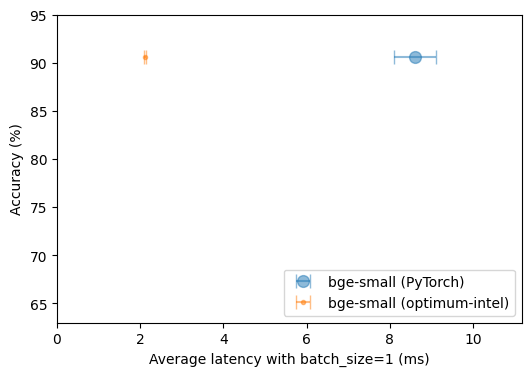

Latency speedup for 'bge-small (optimum-intel)': 4.06x


In [13]:
pb = PerformanceBenchmark(
    optimum_setfit_model,
    test_dataset,
    "bge-small (optimum-intel)",
    batch_sizes=BATCH_SIZES,
    model_path=optimum_model_path,
    enable_autocast=True
)

perf_metrics.update(pb.run_benchmark())
plot_metrics(perf_metrics)

speedup = perf_metrics['bge-small (PyTorch)']['time_avg_ms'] / perf_metrics['bge-small (optimum-intel)']['time_avg_ms']
print(f"Latency speedup for 'bge-small (optimum-intel)': {speedup:.2f}x")

#### After optimizing, inference is 4.06x faster than before, with no drop in accuracy!

### Throughput Speedup

Let's look now at the throughput, which is the number of samples the model can predict per second.\
We'll plot this value for our optimized and baseline models, as a function of the batch size.

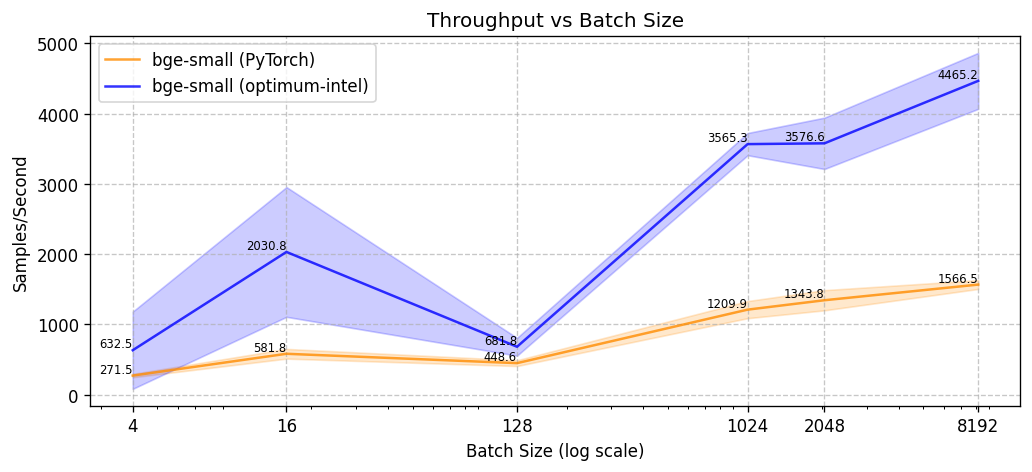

In [14]:
def plot_2_throughputs(perf_metrics):
    xs = np.array(BATCH_SIZES)
    plt.figure(figsize=(10, 4), dpi=120)
    for (label, metric), color in zip(perf_metrics.items(), ["darkorange", "blue"]):
        y_mean, y_std = np.array(metric["throughputs_avg"]), np.array(metric["throughputs_std"])
        plt.plot(xs, y_mean, label=label, color=color, alpha=0.8)
        plt.fill_between(xs, y_mean - y_std, y_mean + y_std, color=color, alpha=0.2)
        for x, y in zip(xs, y_mean):
            plt.text(x, y, f'{y:.1f}', ha='right', va='bottom', fontsize=7, color="black")
    plt.xscale('log')
    plt.xticks(BATCH_SIZES, BATCH_SIZES)
    plt.xlabel('Batch Size (log scale)')
    plt.ylabel('Samples/Second')
    plt.title('Throughput vs Batch Size')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
plot_2_throughputs(perf_metrics)

#### Similarly to the latency speedup, we can see that our optmization has resulted in up to  throughput increase as well!